# PyBird Inference Class Demo: Advanced Bayesian Parameter Estimation

This notebook demonstrates the **PyBird Inference class**, providing a comprehensive showcase of advanced Bayesian parameter estimation techniques for cosmological analysis. We explore multiple inference algorithms, acceleration methods, and sampling strategies using the BOSS CMASS NGC dataset.

## **Key Features:**
- **Multiple minimization algorithms** (Minuit, gradient-based)
- **Advanced sampling methods** (Fisher, EMCEE, Taylor expansion)
- **JAX acceleration** with automatic differentiation
- **Symbolic Boltzmann solver** for rapid likelihood evaluation
- **Non-flat Measures** for exploring projection effects 
- **Performance comparisons** between different approaches

* note this demo notebook can take a while (perhaps a few hours!) to run on CPU - if you have a GPU available be sure to use it to see MCMC analysis in ~ minutes and the whole ntebook in less than 15 minutes
---

## **Import Libraries**
Setting up the required libraries for advanced parameter inference:

import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import yaml
from copy import copy

In [ ]:
import os
from getdist import loadMCSamples, plots, mcsamples, MCSamples
import yaml
import numpy as np
import matplotlib.pyplot as plt 
from pybird.fake import Fake

### **PyBird Inference Module**

Importing the core PyBird inference capabilities:

In [2]:
import pybird
from pybird.inference import Inference

## **Configuration Setup**

### **Directory Paths**

Setting up paths to data and configuration directories:

* We're going to do an analysis of some mock BOSS-like data over one sky

In [3]:
rootdir = "../"
datadir = os.path.join(rootdir, 'data')
fakedir = os.path.join(rootdir, 'data', 'fake')

### **BOSS CMASS-like Likelihood Configuration using the `Fake` class**

Loading and configuring the EFT likelihood setup for a mock BOSS CMASS NGC analysis. See the `Fake` demo notebook for further details on how mock data can be easily generated with this class

*This demonstration uses a single sky selection for rapid analysis (~few minutes runtime)

In [4]:
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
fakeconfigdir = os.path.join(fakedir, 'likelihood_config')
template_configfile = os.path.join(fakeconfigdir, 'set_fake_boss_pk_eft.yaml')

BOSS_CMASS_NGC = {
    'n_sky': 1, 
    'zmin': [.43,],
    'zmax': [.70,],
    'zeff': [0.57],
    'Veff': np.array([5])*1.e9, # Mpc^3
    'degsq': [5000],
    'P0': np.array([10])*1.e3 # (Mpc/h)^3
}

s = BOSS_CMASS_NGC

In [5]:
F = Fake(
    s['n_sky'], s['zmin'], s['zmax'], s['zeff'], s['Veff'], s['degsq'], s['P0'], 
    cosmo, likelihood_config_template_file=template_configfile, fiducial_nuisance=None, boltzmann='Symbolic',
    Omega_m_fid=0.310, kmin=0.005, kmax=0.4, dk=0.01, 
    fake_data_filename='fake_cmass_ngc_pk_eft', path_to_data=fakedir, 
    fake_likelihood_config_filename='fake_cmass_ngc_pk_eft', path_to_config=fakeconfigdir
)

jax: on
No fiducial EFT parameters specified, using default ones


In [6]:
F.set()

bsky[i] {'b1': 1.9542, 'b2': 0.4173, 'b4': 0.4173, 'b3': -0.3686, 'cct': 0.1843, 'cr1': -0.8477, 'cr2': -0.8141, 'ce0': 0.0, 'ce1': 0.0, 'ce2': -1.6279, 'cr4': 0.0, 'cr6': 0.0}


In [7]:
config = yaml.full_load(open(os.path.join(fakedir, 'likelihood_config/fake_cmass_ngc_pk_eft.yaml'), 'r'))

---

## **JAX Acceleration Setup**

### **Enabling JAX for High-Performance Computing**

Switching to JAX for automatic differentiation and JIT compilation:

In [8]:
# Enable emulation for additional speedup
config['with_emu'] = True

# Parameter selection for this analysis
free_cosmo_name = ['omega_cdm', 'h', 'ln10^{10}A_s']

print("**Acceleration Features:**")
print(f"   Emulation: {config['with_emu']}")
print(f"   Free Parameters: {free_cosmo_name}")

**Acceleration Features:**
   Emulation: True
   Free Parameters: ['omega_cdm', 'h', 'ln10^{10}A_s']


In [9]:
# Enable JAX with automatic module reload
from pybird.config import set_jax_enabled
set_jax_enabled(True)

from importlib import reload
import pybird
reload(pybird.inference)
from pybird.inference import Inference

print("**JAX Status: Enabled**")

jax: on
**JAX Status: Enabled**


---

## **Parameter Inference Pipeline**

### **Method 1: Minimization with Symbolic Boltzmann**

Using the differentiable Symbolic Boltzmann solver with Minuit minimizer:

In [10]:
# Initialize Inference class with Symbolic Boltzmann solver
print("**Initializing Inference with Symbolic Boltzmann...**")
I = Inference(free_cosmo_name, cosmo, config, boltzmann='Symbolic', verbose=False)

# Setup minimizer and run optimization
I.set_minimizer(minimizer='minuit', jax_jit=True)
print("\n**Running Parameter Minimization...**")
%time chi2, bestfit, free_param_name = I.get_maxp()

**Initializing Inference with Symbolic Boltzmann...**
----- minimisation with minuit -----

**Running Parameter Minimization...**
CPU times: user 470 ms, sys: 108 ms, total: 578 ms
Wall time: 458 ms


In [11]:
# Calculate goodness of fit statistics
from scipy import stats
def pvalue(minchi2, dof): return 1. - stats.chi2.cdf(minchi2, dof)

dof = I.L.y_all.shape[0] - len(free_param_name) - I.L.Ng
print(f"\n**Minimization Results:**")
print(f"   Min χ²: {chi2:.2f}")
print(f"   p-value: {pvalue(chi2, dof):.3f}")
print(f"   DOF: {dof}")

with np.printoptions(precision=3): 
    print(f"   Best-fit {free_param_name}: {bestfit}")




**Minimization Results:**
   Min χ²: 0.00
   p-value: 1.000
   DOF: 42
   Best-fit ['omega_cdm', 'h', 'ln10^{10}A_s', 'b1', 'b2', 'b4']: [0.12  0.675 3.044 1.954 0.417 0.417]


### **Method 2: Bayesian Sampling with Multiple Algorithms**

Exploring the posterior distribution using both Fisher approximation and MCMC sampling:

*Note: EMCEE is blazingly fast as we utilize the natural vectorization afforded by JAX `vmap`*

In [12]:
# Fisher matrix sampling (Gaussian approximation)
print("**Setting up Fisher Matrix Sampling...**")
sampler = "fisher"
%time I.set_sampler(sampler=sampler, jax_jit=True, measure=False, taylor=False)

print("\n**Generating Fisher Samples...**")
%time samples_fisher, free_param_name = I.get_p()

**Setting up Fisher Matrix Sampling...**
----- sampling with fisher -----
starting from previously found best-fit
CPU times: user 1.83 s, sys: 152 ms, total: 1.98 s
Wall time: 907 ms

**Generating Fisher Samples...**
CPU times: user 15.5 s, sys: 815 ms, total: 16.4 s
Wall time: 7.4 s


/Users/pierre/github/pybird/pybird/inference.py:199: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = multivariate_normal(initial_pos, self.C_fisher, size=size)


In [13]:
# EMCEE sampling with full posterior exploration
print("**Setting up EMCEE Sampling...**")
sampler = "emcee"
options = {'num_samples': 4000, 'discard': 2000, 'thin': 10, 'n_walkers': 32}
%time I.set_sampler(sampler=sampler, jax_jit=True, options=options, measure=False, taylor=False)

print("\n**Generating EMCEE Samples...**")
%time samples_emcee, free_param_name = I.get_p()

**Setting up EMCEE Sampling...**
----- sampling with emcee -----
starting from previously found best-fit


/Users/pierre/github/pybird/pybird/inference.py:211: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  self.pos = multivariate_normal(initial_pos, self.C_fisher, size=n_walkers)


CPU times: user 1.85 s, sys: 143 ms, total: 1.99 s
Wall time: 950 ms

**Generating EMCEE Samples...**
Fisher matrix found: drawing initial conditions from multivariate normal


100%|██████████| 4000/4000 [03:38<00:00, 18.28it/s]

autocorr time:  [58. 63. 70. 73. 65. 54.]
CPU times: user 4min 38s, sys: 1min 44s, total: 6min 22s
Wall time: 3min 38s


---

## **Results Visualization**

### **Posterior Comparison: Fisher vs EMCEE**

Creating triangle plots to compare sampling methods:

In [14]:
# Setup parameter labels for plotting
latex_name_map = {
    'omega_cdm'     : r'\omega_{\mathrm{cdm}}',
    'h'             : r'h',
    'ln10^{10}A_s'  : r'\ln(10^{10}A_s)',
}

labels = [latex_name_map.get(p, p) for p in free_param_name]
print(f"**Parameter Labels:** {labels}")

**Parameter Labels:** ['\\omega_{\\mathrm{cdm}}', 'h', '\\ln(10^{10}A_s)', 'b1', 'b2', 'b4']


**Creating Triangle Plot Comparison...**
Removed no burn in
Removed no burn in


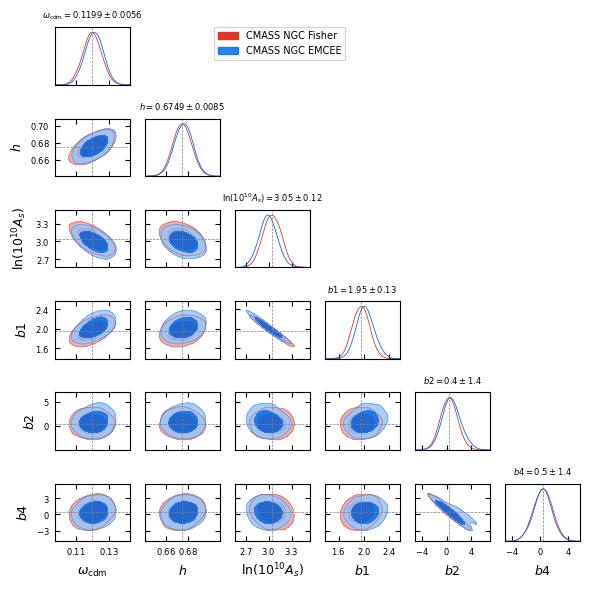

✓ Fisher vs EMCEE comparison completed!


In [15]:
# Create GetDist samples for visualization
%matplotlib inline 
print("**Creating Triangle Plot Comparison...**")

mcsamples_fisher = MCSamples(samples=samples_fisher, names=free_param_name, labels=labels)
mcsamples_emcee = MCSamples(samples=samples_emcee, names=free_param_name, labels=labels)

# Generate triangle plot
g = plots.get_subplot_plotter(width_inch=6) 
g.triangle_plot(
    [mcsamples_fisher, mcsamples_emcee], 
    free_param_name, 
    filled=True, 
    markers=bestfit, 
    title_limit=1, 
    legend_labels=['CMASS NGC Fisher', 'CMASS NGC EMCEE']
)
plt.tight_layout()
plt.show()

print("✓ Fisher vs EMCEE comparison completed!")

---

## **Advanced Acceleration Methods**

### **Method 3: Taylor Expansion Acceleration**

Implementing 3rd order Taylor expansion around the best-fit theory model. This can take a few minutes to compute derivatives...

*This method provides a speedup by approximating the theory model locally, especially good for rapid derivatives*

In [16]:
# Setup EMCEE with Taylor expansion
print("**Setting up Taylor Expansion Sampling...**")
%time I.set_sampler(sampler='emcee', options=options, jax_jit=True, measure=False, taylor=True)

print("\n**Generating Taylor-Accelerated Samples...**")
%time samples, free_param_name = I.get_p()

**Setting up Taylor Expansion Sampling...**
----- sampling with emcee -----
Taylor: expanding cosmology-dependent correlator pieces...
Taylor: best-fit values found --- using them as fiducials


/Users/pierre/github/pybird/pybird/inference.py:211: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  self.pos = multivariate_normal(initial_pos, self.C_fisher, size=n_walkers)


Taylor: derivatives up to order 3 computed in 22.255 sec.
starting from previously found best-fit
CPU times: user 46.2 s, sys: 2.97 s, total: 49.2 s
Wall time: 22.4 s

**Generating Taylor-Accelerated Samples...**
Fisher matrix found: drawing initial conditions from multivariate normal


100%|██████████| 4000/4000 [00:12<00:00, 328.94it/s]
N/50 = 80;
tau: [68.90631949 68.99137108 68.91038712 74.77157088 84.37971748 61.9922422 ]


autocorr time:  [69. 69. 69. 75. 84. 62.]
CPU times: user 16.7 s, sys: 3.02 s, total: 19.7 s
Wall time: 13.2 s


**Creating Taylor vs Full EMCEE Comparison...**
Removed no burn in


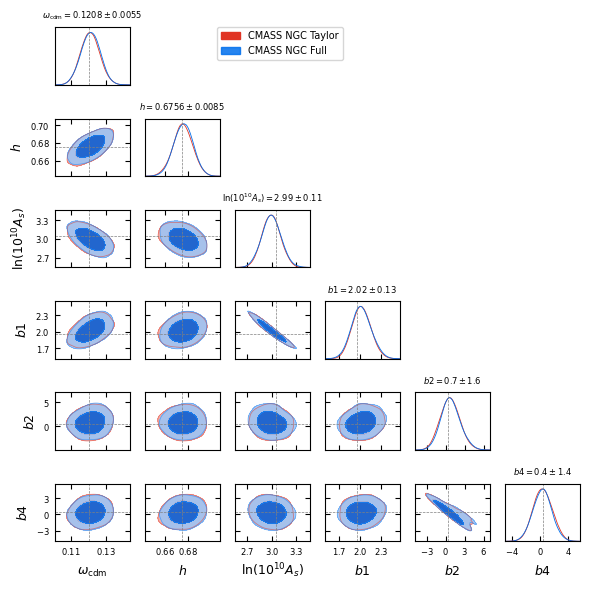

✓ Taylor expansion comparison completed!


In [17]:
# Compare Taylor vs full EMCEE sampling
print("**Creating Taylor vs Full EMCEE Comparison...**")

mcsamples_taylor = MCSamples(samples=samples, names=free_param_name, labels=labels)
g = plots.get_subplot_plotter(width_inch=6) 
g.triangle_plot(
    [mcsamples_taylor, mcsamples_emcee], 
    free_param_name, 
    filled=True, 
    markers=bestfit, 
    title_limit=1, 
    legend_labels=['CMASS NGC Taylor', 'CMASS NGC Full']
)
plt.tight_layout()
plt.show()

print("✓ Taylor expansion comparison completed!")

### **Method 4: Non-flat measure**

*Running analysis with measurement effects incorporated on-the-fly*

* There are two 'hessian_types' options: 'F' corresponding to the usual Jeffrey's measure or 'FH', which corresponds to adding the extra term derived in our paper. Here we will stick with just 'F' for computational speed. 
* As described in the paper "Debiasing inference in large-scale structure with non-flat volume measures", we have two modes: either running with this measure om-the-fly or using it in a "post-debiasing" step. Lets begin with the latter...
* We use taylor here again but notice that `PyBird` does not recompute the derivatives as there is no  update in the fiducial parameters so we can immediately start sampling! 

In [18]:
print("**Setting up Fisher inverse debiasing...**")
%time I.set_sampler(sampler='emcee', jax_jit=True, measure=False, debiasing=True, options=options, taylor=True, hessian_type="F")

%time samples_debiasing, free_param_name = I.get_p()

**Setting up Fisher inverse debiasing...**
----- sampling with emcee -----
Taylor expansion found, with no update in fiducials: using existing.
starting from previously found best-fit
Caching model best-fit
Computing debiasing...
starting from previously found best-fit


/Users/pierre/github/pybird/pybird/inference.py:211: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  self.pos = multivariate_normal(initial_pos, self.C_fisher, size=n_walkers)


Debiasing computed in 13.768 sec.
CPU times: user 21.9 s, sys: 1.38 s, total: 23.3 s
Wall time: 18.3 s
Fisher matrix found: drawing initial conditions from multivariate normal


100%|██████████| 4000/4000 [00:12<00:00, 321.45it/s]


autocorr time:  [53. 58. 59. 59. 73. 66.]
CPU times: user 16.6 s, sys: 2.78 s, total: 19.3 s
Wall time: 13.2 s


In [19]:
# Setup sampling with Jeffrey's measure on the fly 
# this requires more samples to coverge typically so lets chenge this in options 
# This is ~10x slower than debiasing as we have an extra term in the likelihood to compute and we need more samples before convergence... good time for a coffee!

options = {'num_samples': 12000, 'discard': 10000, 'thin': 10, 'n_walkers': 32} 

print("**Setting up Fisher inverse on-the-fly...**")
%time I.set_sampler(sampler='emcee', jax_jit=True, measure=True, debiasing=False, options=options, taylor=True, hessian_type="F")

%time samples_measure, free_param_name = I.get_p()

**Setting up Fisher inverse on-the-fly...**
----- sampling with emcee -----
Taylor expansion found, with no update in fiducials: using existing.
starting from previously found best-fit
Caching model best-fit
CPU times: user 8.29 s, sys: 569 ms, total: 8.86 s
Wall time: 5.66 s
Fisher matrix found: drawing initial conditions from multivariate normal


100%|██████████| 12000/12000 [05:51<00:00, 34.13it/s]


autocorr time:  [116.  98. 121. 130. 184.  82.]
CPU times: user 11min 54s, sys: 10min 43s, total: 22min 38s
Wall time: 5min 52s


**Creating Measurement Effects Comparison...**
Removed no burn in
Removed no burn in


/var/folders/ln/m6nw7b5d1h11560h9hnwzdf00000gp/T/ipykernel_64616/1086891828.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


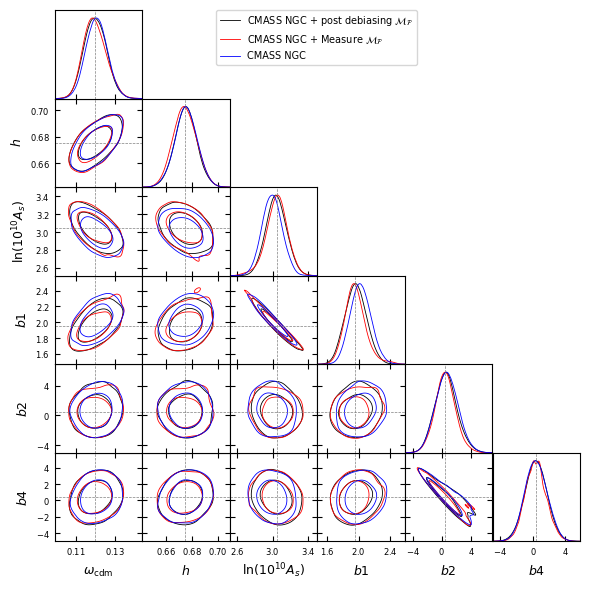

✓ Jeffrey's measure analysis completed!


In [20]:
# Compare measurement effects vs flat prior
print("**Creating Measurement Effects Comparison...**")
mcsamples_debiasing = MCSamples(samples=samples_debiasing, names=free_param_name, labels=labels)
mcsamples_measure = MCSamples(samples=samples_measure, names=free_param_name, labels=labels)
g = plots.get_subplot_plotter(width_inch=6) 
g.triangle_plot(
    [mcsamples_debiasing, mcsamples_measure, mcsamples_taylor], 
    free_param_name, 
    filled=False, 
    markers=bestfit, 
    legend_labels=[r'CMASS NGC + post debiasing $\mathcal{M}_{\mathcal{F}}$', r'CMASS NGC + Measure $\mathcal{M}_{\mathcal{F}}$', 'CMASS NGC']
)
plt.tight_layout()
plt.show()

print("✓ Jeffrey's measure analysis completed!")

### Now lets see - did we debias the chains actually? 
* Lets see how close the expectation value of the marginalized posterior is to the input cosmology 

In [21]:
# finally we can see if we recover the truth with the Fisher measure

samples_dict = {"flat":mcsamples_taylor, 
                r"debiasing $\mathcal{M}_{\mathcal{F}}$": mcsamples_debiasing, 
               r"measure $\mathcal{M}_{\mathcal{F}}$":mcsamples_measure}

cosmo_var = ["omega_cdm", "h", "ln10^{10}A_s"]

def get_relative_shifts_from_truth(samples, cosmo, truth):
    shifts = []
    allstats = samples.getMargeStats()
    for i, name in enumerate(cosmo):
        stats = allstats.parWithName(name)
        mean = stats.mean
        err = stats.err
        delta = mean-truth[name]
        shift = delta / err
        shifts.append(shift)
    return np.array( shifts )


def print_shift_table(samples_dict, cosmo_var, truth):
    col_w = 16  # tweak to suit your names / numbers

    # header with Δparam/σ labels
    header = ["Chain"] + [f"Δ{p}/σ" for p in cosmo_var]
    print("".join(f"{h:<{col_w}}" for h in header))
    print("-" * (col_w * len(header)))

    # rows
    for label, samples in samples_dict.items():
        shifts = get_relative_shifts_from_truth(samples, cosmo_var, truth)
        row = [label] + [f"{s:+.2f}" for s in shifts]
        print("".join(f"{cell:<{col_w}}" for cell in row))


# ---- use it ----
cosmo_var = ["omega_cdm", "h", "ln10^{10}A_s"]
print_shift_table(samples_dict, cosmo_var, cosmo)

Chain           Δomega_cdm/σ    Δh/σ            Δln10^{10}A_s/σ 
----------------------------------------------------------------
flat            +0.15           +0.07           -0.46           
debiasing $\mathcal{M}_{\mathcal{F}}$+0.02           +0.04           -0.04           
measure $\mathcal{M}_{\mathcal{F}}$-0.02           -0.04           -0.00           
